
# <center>NYC Taxi Data Analysis</center>

<center>by Ryan Felix</center>

# Environment Setup

## Library Imports

In [1]:
#load packages
import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display 
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time
from datetime import datetime
import re


print('-'*25)

Python version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 0.24.2
matplotlib version: 3.1.1
NumPy version: 1.16.4
SciPy version: 1.3.1
IPython version: 7.8.0
scikit-learn version: 0.21.3
-------------------------


## Data Modeling Libraries

In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier,XGBRegressor

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import cufflinks as cf

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

## Import Data

In [3]:
taxi_data=pd.read_csv('yellow_tripdata_2018-01.csv')
zone_lookup=pd.read_csv('taxi+_zone_lookup.csv')

In [4]:
zone_lookup.head(10)

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone
5           6  Staten Island  Arrochar/Fort Wadsworth    Boro Zone
6           7         Queens                  Astoria    Boro Zone
7           8         Queens             Astoria Park    Boro Zone
8           9         Queens               Auburndale    Boro Zone
9          10         Queens             Baisley Park    Boro Zone

In [5]:
taxi_data.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1         1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2         1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3         1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4         1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.5           1                  N            41            24   
1            2.7           1                  N           239           140   
2            0.8           1                  N           262           141   
3           10.2           1                  N           140           257   
4            2.5           1                  N           246           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          4.5    0.5      0.5        0.00           0.0   
1             2         14.0    0.5      0.5        0.00           0.0   
2             1          6.0    0.5      0.5        1.00           0.0   
3             2         33.5    0.5      0.5        0.00           0.0   
4             1         12.5    0.5      0.5        2.75           0.0   

   improvement_surcharge  total_amount  
0                    0.3          5.80  
1                    0.3         15.30  
2                    0.3          8.30  
3                    0.3         34.80  
4                    0.3         16.55

In [6]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759874 entries, 0 to 8759873
Data columns (total 17 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
RatecodeID               int64
store_and_fwd_flag       object
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 1.1+ GB


In [7]:
# Rename some columns
taxi_data.rename(columns={'tpep_pickup_datetime':'pickup_time','tpep_dropoff_datetime':'dropoff_time'},inplace=True) 
taxi_data.isnull().sum() # Make sure there are no null values

VendorID                 0
pickup_time              0
dropoff_time             0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

# Analysis

### 1. What one-hour window in January 2018 saw the highest number of taxi pickups?

In [8]:
taxi_data['pickup_time'][0]

'2018-01-01 00:21:05'

In [9]:
type(taxi_data['pickup_time'][0]) # These aren't datetime objects, but strings, so let's fix that

str

In [10]:
# Here we format both the pickup and dropoff times to datetime objects

taxi_data['pickup_time']=pd.to_datetime(taxi_data['pickup_time'],format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_time']=pd.to_datetime(taxi_data['dropoff_time'],format='%Y-%m-%d %H:%M:%S')

In [11]:
# Let's check the range of the pickup times

print(taxi_data['pickup_time'].min())
print(taxi_data['pickup_time'].max())

2001-01-05 11:45:23
2018-07-27 04:06:37


In [12]:
# Now we will cut the pickup times into 24*31 equally spaced bins and count the values in each,
# but we need to specify that the pickup times are only in January of 2018

pd.cut(taxi_data[(taxi_data['pickup_time']>'2017-12-31 23:59:59')&
                 (taxi_data['pickup_time']<'2018-02-01 00:00:00')]['pickup_time'],24*31).value_counts().idxmax()

Interval('2018-01-26 17:59:57.508064512', '2018-01-26 18:59:57.504032256', closed='right')

#### We can see that the hour in January of 2018 with the most pickups was on January 26th from 18:00 to 19:00 (6-7 PM)

### 2. Fare Predicting 

Taxi Fares are calculated using a 2.50 Dollar base fare plus 50 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when vehicle is stopped. We will build a model that takes the trip duration and distance as inputs and predicts the fare amount

In [13]:
# Let's look at the dataframe with necessary columns

taxi_data[['pickup_time','dropoff_time','trip_distance','fare_amount']].head()

pickup_time        dropoff_time  trip_distance  fare_amount
0 2018-01-01 00:21:05 2018-01-01 00:24:23            0.5          4.5
1 2018-01-01 00:44:55 2018-01-01 01:03:05            2.7         14.0
2 2018-01-01 00:08:26 2018-01-01 00:14:21            0.8          6.0
3 2018-01-01 00:20:22 2018-01-01 00:52:51           10.2         33.5
4 2018-01-01 00:09:18 2018-01-01 00:27:06            2.5         12.5

In [14]:
# Let's create a duration column by subtracting the two datetime objects and then calling the total_seconds method
# We divide by 60 to convert it into minutes

taxi_data['duration']=(taxi_data['dropoff_time']-taxi_data['pickup_time']).dt.total_seconds()/60

In [15]:
taxi_data[['duration','trip_distance','fare_amount']].head()

duration  trip_distance  fare_amount
0   3.300000            0.5          4.5
1  18.166667            2.7         14.0
2   5.916667            0.8          6.0
3  32.483333           10.2         33.5
4  17.800000            2.5         12.5

In [16]:
fare_model=taxi_data[['duration','trip_distance','fare_amount']]

In [17]:
fare_model.head()

duration  trip_distance  fare_amount
0   3.300000            0.5          4.5
1  18.166667            2.7         14.0
2   5.916667            0.8          6.0
3  32.483333           10.2         33.5
4  17.800000            2.5         12.5

In [18]:
# Now let's do a train-test-split on the data

from sklearn.model_selection import train_test_split

X=fare_model.drop('fare_amount',axis=1)
y=fare_model['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [19]:
# Simple Linear Regression Model

from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train,y_train)

print(f'Coefficients: {reg.coef_}')
print(f'Intercept: {reg.intercept_}')

predictions = reg.predict(X_test)

Coefficients: [0.02890306 0.00595515]
Intercept: 11.781040410981047


Not great performance from the model. It has the intercept as 11.78 dollars, which we would want to be closer to the base rate of 2.50. Basically it looks like it just picked an average value for the intercept and then barely scales the other inputs so as to not stray too far from this average.

In [20]:
# Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error


print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 6.608302767147878
MSE: 120.02174794722762
RMSE: 10.9554437585717


Again, very poor from the model. Let's try a XGB Regressor and see what we can do

In [21]:
# XGB Regressor

xgb = XGBRegressor(max_depth=2,objective='reg:squarederror',verbosity=1,n_estimators=50).fit(X_train,y_train)
xpreds = xgb.predict(X_test)


/Users/rfelix/anaconda3/envs/New/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[17:51:30] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [22]:
# Measure the performance
print('MAE:', metrics.mean_absolute_error(y_test, xpreds))
print('MSE:', metrics.mean_squared_error(y_test, xpreds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xpreds)))

MAE: 0.933085884074725
MSE: 23.696377095340445
RMSE: 4.8678924695745325


Here we can see our performance compared to the linear regression model was notably better. It was still difficult to reverse engineer the fares, and this model doesn't have interpretable coefficients to look at. We could try different variations of the XGB Regressor parameters to improve the model.




### 3. Features of Rides with Generous Tips

By generous and not just large, we will assume that we are looking for tips that are a high relative to the fare amount. 
One limitation to note is that the tips listed in the data are only from credit cards and not cash.

In [23]:
taxi_data.head()

VendorID         pickup_time        dropoff_time  passenger_count  \
0         1 2018-01-01 00:21:05 2018-01-01 00:24:23                1   
1         1 2018-01-01 00:44:55 2018-01-01 01:03:05                1   
2         1 2018-01-01 00:08:26 2018-01-01 00:14:21                2   
3         1 2018-01-01 00:20:22 2018-01-01 00:52:51                1   
4         1 2018-01-01 00:09:18 2018-01-01 00:27:06                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.5           1                  N            41            24   
1            2.7           1                  N           239           140   
2            0.8           1                  N           262           141   
3           10.2           1                  N           140           257   
4            2.5           1                  N           246           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          4.5    0.5      0.5        0.00           0.0   
1             2         14.0    0.5      0.5        0.00           0.0   
2             1          6.0    0.5      0.5        1.00           0.0   
3             2         33.5    0.5      0.5        0.00           0.0   
4             1         12.5    0.5      0.5        2.75           0.0   

   improvement_surcharge  total_amount   duration  
0                    0.3          5.80   3.300000  
1                    0.3         15.30  18.166667  
2                    0.3          8.30   5.916667  
3                    0.3         34.80  32.483333  
4                    0.3         16.55  17.800000

In [24]:
taxi_data['tip_rate']=taxi_data['tip_amount']/taxi_data['fare_amount']

In [25]:
taxi_data.corr()

VendorID  passenger_count  trip_distance  RatecodeID  \
VendorID               1.000000         0.267994       0.001872    0.005514   
passenger_count        0.267994         1.000000       0.000522   -0.005584   
trip_distance          0.001872         0.000522       1.000000    0.014077   
RatecodeID             0.005514        -0.005584       0.014077    1.000000   
PULocationID          -0.023612        -0.006357      -0.004947   -0.007419   
DOLocationID          -0.019265        -0.005834      -0.005147   -0.002444   
payment_type          -0.020219         0.006844      -0.002444   -0.004449   
fare_amount            0.021532         0.007647       0.047832    0.333151   
extra                  0.004183         0.003691       0.004968    0.021063   
mta_tax                0.000166         0.002392      -0.008933   -0.294935   
tip_amount             0.018202        -0.002187       0.032267    0.205772   
tolls_amount           0.011613         0.006236       0.028750    0.212882   
improvement_surcharge -0.020663        -0.002822      -0.006079   -0.068877   
total_amount           0.022659         0.006852       0.048666    0.335996   
duration               0.040215         0.013615       0.008376    0.029155   
tip_rate              -0.001497        -0.000322      -0.000002    0.012239   

                       PULocationID  DOLocationID  payment_type  fare_amount  \
VendorID                  -0.023612     -0.019265     -0.020219     0.021532   
passenger_count           -0.006357     -0.005834      0.006844     0.007647   
trip_distance             -0.004947     -0.005147     -0.002444     0.047832   
RatecodeID                -0.007419     -0.002444     -0.004449     0.333151   
PULocationID               1.000000      0.120565     -0.014303    -0.069379   
DOLocationID               0.120565      1.000000     -0.015671    -0.078821   
payment_type              -0.014303     -0.015671      1.000000    -0.054802   
fare_amount               -0.069379     -0.078821     -0.054802     1.000000   
extra                     -0.014515     -0.020101     -0.026549     0.058948   
mta_tax                   -0.001417      0.028718     -0.048126    -0.074306   
tip_amount                -0.040456     -0.043833     -0.471599     0.561933   
tolls_amount              -0.038281     -0.037284     -0.034684     0.464404   
improvement_surcharge      0.000040      0.000815     -0.085949     0.031026   
total_amount              -0.069367     -0.077683     -0.133184     0.980044   
duration                  -0.014291     -0.016973     -0.003787     0.147414   
tip_rate                   0.000828      0.000923     -0.012824    -0.001877   

                          extra   mta_tax  tip_amount  tolls_amount  \
VendorID               0.004183  0.000166    0.018202      0.011613   
passenger_count        0.003691  0.002392   -0.002187      0.006236   
trip_distance          0.004968 -0.008933    0.032267      0.028750   
RatecodeID             0.021063 -0.294935    0.205772      0.212882   
PULocationID          -0.014515 -0.001417   -0.040456     -0.038281   
DOLocationID          -0.020101  0.028718   -0.043833     -0.037284   
payment_type          -0.026549 -0.048126   -0.471599     -0.034684   
fare_amount            0.058948 -0.074306    0.561933      0.464404   
extra                  1.000000  0.027847    0.077107      0.041796   
mta_tax                0.027847  1.000000   -0.102295     -0.184062   
tip_amount             0.077107 -0.102295    1.000000      0.383648   
tolls_amount           0.041796 -0.184062    0.383648      1.000000   
improvement_surcharge  0.031963  0.517494    0.015111      0.004138   
total_amount           0.098944 -0.097126    0.686865      0.572640   
duration               0.015161 -0.007943    0.083601      0.068661   
tip_rate              -0.000133 -0.015763    0.044163      0.004869   

                       improvement_surcharge  total_amount  duration  tip_rate  
VendorID                     

In [26]:
generous=taxi_data[taxi_data['tip_rate']>1] # Particulary generous tips are where the tip is as much as the fare

In [27]:
generous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7268 entries, 349 to 8759738
Data columns (total 19 columns):
VendorID                 7268 non-null int64
pickup_time              7268 non-null datetime64[ns]
dropoff_time             7268 non-null datetime64[ns]
passenger_count          7268 non-null int64
trip_distance            7268 non-null float64
RatecodeID               7268 non-null int64
store_and_fwd_flag       7268 non-null object
PULocationID             7268 non-null int64
DOLocationID             7268 non-null int64
payment_type             7268 non-null int64
fare_amount              7268 non-null float64
extra                    7268 non-null float64
mta_tax                  7268 non-null float64
tip_amount               7268 non-null float64
tolls_amount             7268 non-null float64
improvement_surcharge    7268 non-null float64
total_amount             7268 non-null float64
duration                 7268 non-null float64
tip_rate                 7268 non-null fl

In [28]:
generous.corr()

VendorID  passenger_count  trip_distance  RatecodeID  \
VendorID               1.000000         0.295817      -0.072107   -0.065799   
passenger_count        0.295817         1.000000       0.000745   -0.026074   
trip_distance         -0.072107         0.000745       1.000000    0.131370   
RatecodeID            -0.065799        -0.026074       0.131370    1.000000   
PULocationID           0.054674         0.023126      -0.056451    0.017630   
DOLocationID          -0.013325        -0.013275       0.032993    0.047784   
payment_type           0.011934         0.005559      -0.006900   -0.002241   
fare_amount            0.019517         0.029002       0.635215    0.014831   
extra                  0.033685         0.021834       0.014171   -0.055591   
mta_tax                0.033689        -0.000248      -0.076097    0.701389   
tip_amount             0.010938         0.029901       0.445237    0.099552   
tolls_amount          -0.056321        -0.010066       0.182235    0.062839   
improvement_surcharge  0.027360         0.013689      -0.012808   -0.089963   
total_amount          -0.000504         0.029000       0.569754    0.106813   
duration               0.033478         0.030282       0.140107    0.012064   
tip_rate              -0.052891        -0.004523       0.039620    0.436843   

                       PULocationID  DOLocationID  payment_type  fare_amount  \
VendorID                   0.054674     -0.013325      0.011934     0.019517   
passenger_count            0.023126     -0.013275      0.005559     0.029002   
trip_distance             -0.056451      0.032993     -0.006900     0.635215   
RatecodeID                 0.017630      0.047784     -0.002241     0.014831   
PULocationID               1.000000      0.412332     -0.001395    -0.047863   
DOLocationID               0.412332      1.000000     -0.000662     0.004649   
payment_type              -0.001395     -0.000662      1.000000    -0.030409   
fare_amount               -0.047863      0.004649     -0.030409     1.000000   
extra                     -0.024840     -0.044077     -0.037130     0.113747   
mta_tax                    0.036685      0.022510     -0.066601    -0.013538   
tip_amount                -0.012002      0.031325     -0.036929     0.421989   
tolls_amount               0.005259      0.020617     -0.001959     0.065693   
improvement_surcharge      0.046902      0.050227     -0.344192    -0.003918   
total_amount              -0.020493      0.031539     -0.039523     0.616991   
duration                  -0.001974      0.017231     -0.002983     0.145199   
tip_rate                   0.015951      0.019983     -0.001110    -0.042429   

                          extra   mta_tax  tip_amount  tolls_amount  \
VendorID               0.033685  0.033689    0.010938     -0.056321   
passenger_count        0.021834 -0.000248    0.029901     -0.010066   
trip_distance          0.014171 -0.076097    0.445237      0.182235   
RatecodeID            -0.055591  0.701389    0.099552      0.062839   
PULocationID          -0.024840  0.036685   -0.012002      0.005259   
DOLocationID          -0.044077  0.022510    0.031325      0.020617   
payment_type          -0.037130 -0.066601   -0.036929     -0.001959   
fare_amount            0.113747 -0.013538    0.421989      0.065693   
extra                  1.000000  0.005325    0.035286     -0.005452   
mta_tax                0.005325  1.000000   -0.059610     -0.031018   
tip_amount             0.035286 -0.059610    1.000000      0.086593   
tolls_amount          -0.005452 -0.031018    0.086593      1.000000   
improvement_surcharge -0.019025  0.273936   -0.003381     -0.001922   
total_amount           0.069478 -0.048187    0.930143      0.357930   
duration               0.023468 -0.009548    0.077885      0.023951   
tip_rate              -0.041294 -0.185903    0.109540      0.033986   

                       improvement_surcharge  total_amount  duration  tip_rate  
VendorID                     

In [29]:
generous['RatecodeID'].value_counts(normalize=True)

1     0.969180
5     0.020088
2     0.006604
3     0.001926
4     0.001513
6     0.000550
99    0.000138
Name: RatecodeID, dtype: float64

In [30]:
taxi_data['RatecodeID'].value_counts(normalize=True)

1     0.974044
2     0.020464
5     0.003166
3     0.001727
4     0.000580
99    0.000012
6     0.000008
Name: RatecodeID, dtype: float64

There's not much of a difference between their final rate code (has to do with where they end up)

In [31]:
generous['trip_distance'].mean()

1.3805861309851402

In [32]:
taxi_data['trip_distance'].mean()

2.8040011340345794

This should be fairly obvious, but generous tips are much more common with shorter trips, since the tip is smaller. 

In [33]:
generous['tolls_amount'].mean()

0.5940162355531095

In [34]:
taxi_data['tolls_amount'].mean()

0.3026133401005544

Here we see larger tolls paid with more generous tips, perhaps those people are just wealthier in general.

In [35]:
large_tips=taxi_data[taxi_data['tip_amount']>10] # Let's look at large tips

In [36]:
large_tips['trip_distance'].mean()

15.721679876486105

In [37]:
large_tips['tolls_amount'].mean()

4.647841444662523

Here we see a much higher average trip distance for large tippers than in general, which again makes sense, considering that tips are usually a percentage of the fare, which of course is very highly correlated with trip distance. Similarly, toll amounts are much higher with large tippers, since they are likely just paying a percentage of their higher fare. In general, we see that generous tippers (relative to their total fare) usually have short rides but take more tolls, and large tippers (overall) have longer rides and additionally have longer tolls. 

## 4. Demand Visualization for Time of Day and Day of Week

In [38]:
# From the datetime objects we can extract the day of the week using the weekday method

taxi_data['weekday']=taxi_data['pickup_time'].apply(lambda x: x.weekday())

In [39]:
# Now we can map the integers to the name of the day

taxi_data['weekday']=taxi_data['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
taxi_data.head()

VendorID         pickup_time        dropoff_time  passenger_count  \
0         1 2018-01-01 00:21:05 2018-01-01 00:24:23                1   
1         1 2018-01-01 00:44:55 2018-01-01 01:03:05                1   
2         1 2018-01-01 00:08:26 2018-01-01 00:14:21                2   
3         1 2018-01-01 00:20:22 2018-01-01 00:52:51                1   
4         1 2018-01-01 00:09:18 2018-01-01 00:27:06                2   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            0.5           1                  N            41            24   
1            2.7           1                  N           239           140   
2            0.8           1                  N           262           141   
3           10.2           1                  N           140           257   
4            2.5           1                  N           246           239   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          4.5    0.5      0.5        0.00           0.0   
1             2         14.0    0.5      0.5        0.00           0.0   
2             1          6.0    0.5      0.5        1.00           0.0   
3             2         33.5    0.5      0.5        0.00           0.0   
4             1         12.5    0.5      0.5        2.75           0.0   

   improvement_surcharge  total_amount   duration  tip_rate weekday  
0                    0.3          5.80   3.300000  0.000000  Monday  
1                    0.3         15.30  18.166667  0.000000  Monday  
2                    0.3          8.30   5.916667  0.166667  Monday  
3                    0.3         34.80  32.483333  0.000000  Monday  
4                    0.3         16.55  17.800000  0.220000  Monday

In [40]:
# We have the weekday, now we can create a new column for the hour, which we extract from the datetime object

taxi_data['pickup_hour']=taxi_data['pickup_time'].apply(lambda x: x.hour)
taxi_data[['pickup_time','pickup_hour']].sample(n=10)

pickup_time  pickup_hour
1662239 2018-01-08 05:42:25            5
7506711 2018-01-27 17:42:46           17
5547481 2018-01-21 02:52:25            2
1055028 2018-01-05 19:56:46           19
8207406 2018-01-30 09:46:24            9
4324405 2018-01-17 09:10:43            9
915896  2018-01-05 09:24:24            9
8034589 2018-01-29 16:16:15           16
6394228 2018-01-24 10:44:31           10
1856890 2018-01-08 19:53:35           19

In [41]:
viz_frame=taxi_data[['weekday','pickup_time','pickup_hour']]
wd=viz_frame.groupby(['weekday','pickup_hour'])

In [42]:
# Here I will create a new data frame with this info to make a heatmap
# I'm sure there's a better way to do this...
df=[]
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in weekdays:   #Using taxi_data['weekday'].unique() gave the days out of order
    for j in range(0,24):   #Using taxi_data['pickup_hour'].unique() gave the hours out of order
        count=taxi_data[(taxi_data['weekday']==i)&(taxi_data['pickup_hour']==j)]['pickup_time'].count()
        df.append([i,j,count])
        
df=pd.DataFrame(df,columns=['weekday','pickup_hour','num_rides'])

In [43]:
pvt=df.pivot_table(values='num_rides',index='weekday',columns='pickup_hour')
pvt=pvt.reindex(weekdays) # It likes to alphabetize the days of the week

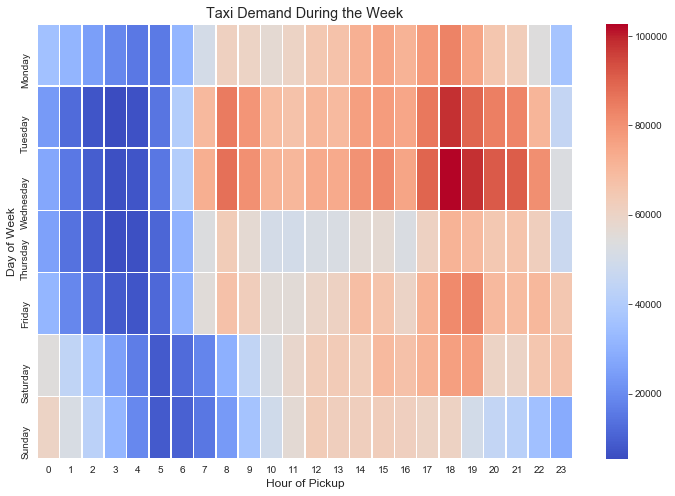

In [44]:
# Now we can create a heatmap

plt.figure(figsize=(12, 8))
hm=sns.heatmap(pvt,cmap='coolwarm',linecolor='white',linewidths=0.5,);
bottom, top = hm.get_ylim();
hm.set_ylim(bottom + 0.5, top - 0.5); #This fixes a bug that cuts off the top and bottom of the plot
hm.set_title('Taxi Demand During the Week');
hm.set_ylabel('Day of Week');
hm.set_xlabel('Hour of Pickup');


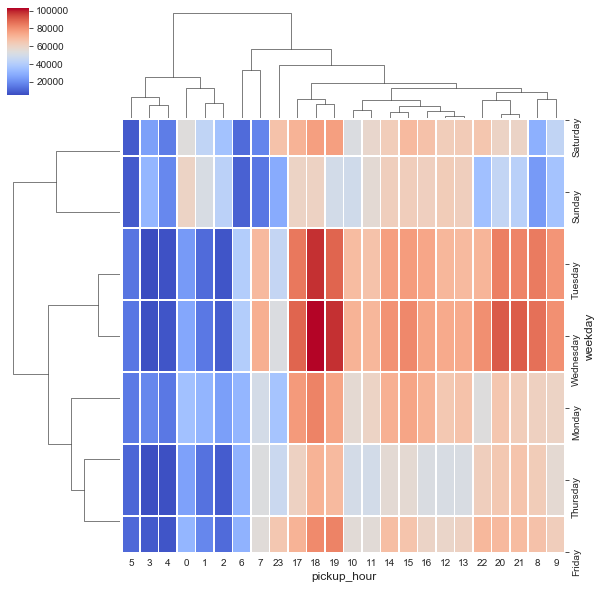

In [45]:
#Here is a different kind of heatmap called a clustermap
cluster = sns.clustermap(pvt,cmap='coolwarm',linecolor='white',linewidths=0.5); 

<center>Tuesday and Wednesday evenings are clearly the busiest times of the week. </center>

## 5. Probabilistic Model to predict drop-off borough given pickup borough, time of day, and day of week

In [46]:
# The first thing we need to do is use the pickup and dropoff location id's to map them to their respective borough
# We will do this using the Taxi Zone Lookup Table dataframe
zone_lookup.set_index('LocationID',inplace=True)
zone_lookup.head(10)

Borough                     Zone service_zone
LocationID                                                     
1                     EWR           Newark Airport          EWR
2                  Queens              Jamaica Bay    Boro Zone
3                   Bronx  Allerton/Pelham Gardens    Boro Zone
4               Manhattan            Alphabet City  Yellow Zone
5           Staten Island            Arden Heights    Boro Zone
6           Staten Island  Arrochar/Fort Wadsworth    Boro Zone
7                  Queens                  Astoria    Boro Zone
8                  Queens             Astoria Park    Boro Zone
9                  Queens               Auburndale    Boro Zone
10                 Queens             Baisley Park    Boro Zone

In [47]:
# We will create a borough dictionary so that we can create two new columns in the taxi_data dataframe

zone_dict=zone_lookup['Borough'].to_dict()

In [48]:
# Here we map those location ID's to their corresponding borough

taxi_data['pu_borough']=taxi_data['PULocationID'].map(zone_dict)
taxi_data['do_borough']=taxi_data['DOLocationID'].map(zone_dict)

In [49]:
taxi_data[['PULocationID','DOLocationID','pu_borough','do_borough']].sample(10)

PULocationID  DOLocationID pu_borough do_borough
6647363           186           249  Manhattan  Manhattan
5610664           233           100  Manhattan  Manhattan
3763699            75            48  Manhattan  Manhattan
8529041            43           141  Manhattan  Manhattan
8146656           237            43  Manhattan  Manhattan
7568428           237           107  Manhattan  Manhattan
3147618           249           261  Manhattan  Manhattan
6973517           234           163  Manhattan  Manhattan
1802523           114           107  Manhattan  Manhattan
5307843           261           231  Manhattan  Manhattan

In [50]:
# For the time of day we will create a new column rather than the use the pickup_hour in order to be more precise 

taxi_data['pick_time']=taxi_data['pickup_time'].apply(lambda x: x.hour+x.minute/60+x.second/3600) 

# pick_time gives us the number of hours that have passed during the day including the minutes and seconds

In [51]:
# Now we can create a new dataframe reduced down to the relevant features

do_prob=taxi_data[['pu_borough','pick_time','weekday','do_borough']]
do_prob.sample(10)

pu_borough  pick_time    weekday do_borough
6431038  Manhattan  12.283056  Wednesday  Manhattan
1948587  Manhattan   8.776111    Tuesday  Manhattan
1788144    Unknown  15.659167     Monday    Unknown
3373140  Manhattan  20.780278   Saturday  Manhattan
3384072  Manhattan  21.612500   Saturday  Manhattan
7085374  Manhattan  12.673056     Friday  Manhattan
2585887  Manhattan  12.752500   Thursday  Manhattan
2562449  Manhattan  10.218056   Thursday  Manhattan
3201981  Manhattan  11.550000   Saturday  Manhattan
3289685  Manhattan  16.027778   Saturday  Manhattan

In [52]:
# Let's take a look at our different boroughs
do_prob['pu_borough'].unique()

array(['Manhattan', 'Queens', 'Bronx', 'Brooklyn', 'Unknown',
       'Staten Island', 'EWR'], dtype=object)

In [53]:
# Let's get rid of all unkown data

do_prob=do_prob[(do_prob['pu_borough']!='Unknown') & (do_prob['do_borough']!='Unknown')]
do_prob['pu_borough'].unique()

array(['Manhattan', 'Queens', 'Bronx', 'Brooklyn', 'Staten Island', 'EWR'],
      dtype=object)

### Thoughts so far
<p>In order to create the model we need to encode the boroughs and the weekdays to numbers that the model can use. I think it's best to use one hot encoding on both the weekdays, considering that there isn't really any type of heirarchy structure on the weekdays. That way, the model in some sense will start at an integer that corresponds with it's borough, then receive some scaled inputs based on the pickup time and the weekday, and then produce a set of probabilities that correspond to the liklihood of being dropped off in each borough. Of course these probabilities must sum to one.</p>
<p><img src='https://www.worldatlas.com/upload/c6/23/73/shutterstock-152208935.jpg' height='600' width='600'></p>
<p>One thing to consider is the integer mapping on the boroughs. Since we are doing this mathematically, there is a notion of distance between the integer values of each borough and ideally we would want this to match up in some way with the actual physical distance between the boroughs. Looking at the map above, it's hard to pick an integer for each borough considering that Queen, Brooklyn, and the Bronx are all right next to Manhattan. For this reason it's probably best to use one hot encoding on the pickup boroughs as well. </p>

<p>Note: This image was found through a google search at this url: https://www.worldatlas.com/upload/c6/23/73/shutterstock-152208935.jpg</p

In [54]:
# Let's one hot encode these two columns

boro=pd.get_dummies(do_prob['pu_borough'],drop_first=True)
wday=pd.get_dummies(do_prob['weekday'],drop_first=True)

In [55]:
matrix=do_prob.drop(['pu_borough','weekday','do_borough'],axis=1)

In [56]:
matrix=pd.concat([matrix,wday,boro],axis=1)

In [57]:
matrix.sample(10)

pick_time  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
5441261  19.194167       0         1       0         0        0          0   
6427523  12.706667       0         0       0         0        0          1   
6455570  14.747500       0         0       0         0        0          1   
2341807  15.308889       0         0       0         0        0          1   
3569016  14.761667       0         0       1         0        0          0   
449903   21.431111       0         0       0         0        1          0   
1258588  14.622778       0         1       0         0        0          0   
1574298  17.615833       0         0       1         0        0          0   
168051   16.651111       1         0       0         0        0          0   
8063421  18.659444       1         0       0         0        0          0   

         Brooklyn  EWR  Manhattan  Queens  Staten Island  
5441261         0    0          1       0              0  
6427523         0    0          1       0              0  
6455570         0    0          1       0              0  
2341807         0    0          1       0              0  
3569016         0    0          1       0              0  
449903          0    0          1       0              0  
1258588         0    0          1       0              0  
1574298         0    0          1       0              0  
168051          0    0          1       0              0  
8063421         0    0          1       0              0

Now we can use this sparse matrix in our model, but first we need to map the drop-off column to integers. 

In [58]:
# Map the Boroughs to integers and do a train test split
X=matrix
y=do_prob['do_borough'].map({'Manhattan':1,'Brooklyn':2,'Bronx':3,'Queens':4,'Staten Island':5,'EWR':6})
y.apply(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [59]:
# Train the Stochastic Gradient Descent Model (maybe a Random Forest as well)
# This model was chosen based on the model selector from sklearn
# https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

sgdc = linear_model.SGDClassifier(verbose=1,loss='modified_huber',n_jobs=-1).fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1
-- Epoch 1
Norm: 2.57, NNZs: 12, Bias: 0.476174, T: 6002416, Avg. loss: 0.334922
Total training time: 4.58 seconds.
-- Epoch 2
Norm: 1.66, NNZs: 12, Bias: -0.807478, T: 6002416, Avg. loss: 2.179649
Norm: 0.81, NNZs: 12, Bias: -0.712119, T: 6002416, Avg. loss: 2.008007
Total training time: 4.72 seconds.
-- Epoch 2
Total training time: 4.74 seconds.
-- Epoch 2
Norm: 1.95, NNZs: 12, Bias: -1.042525, T: 6002416, Avg. loss: 4.215271
Total training time: 4.85 seconds.
-- Epoch 2
Norm: 2.17, NNZs: 12, Bias: 0.272315, T: 12004832, Avg. loss: 0.032096
Total training time: 7.56 seconds.
-- Epoch 3
Norm: 1.39, NNZs: 12, Bias: -0.864765, T: 12004832, Avg. loss: 0.215017Norm: 0.64, NNZs: 12, Bias: -0.751221, T: 12004832, Avg. loss: 0.229298

Total training time: 7.79 seconds.Total training time: 7.78 seconds.

-- Epoch 3-- Epoch 3

Norm: 1.53, NNZs: 12, Bias: -0.653650, T: 12004832, Avg. loss: 0.434636
Total training time: 8.11 seconds.
-- Epoch 3
Norm: 2.14, NNZs: 

Norm: 1.07, NNZs: 12, Bias: -0.920989, T: 36014496, Avg. loss: 0.006663
Total training time: 16.98 seconds.
-- Epoch 7
Norm: 1.07, NNZs: 12, Bias: -0.924582, T: 42016912, Avg. loss: 0.006595
Total training time: 19.18 seconds.
-- Epoch 8
Norm: 1.07, NNZs: 12, Bias: -0.928118, T: 48019328, Avg. loss: 0.006547
Total training time: 21.43 seconds.
Convergence after 8 epochs took 21.43 seconds


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.3min finished


In [60]:
# Predict the classes
preds=sgdc.predict(X_test)
prob_preds=sgdc.predict_proba(X_test)


In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test,preds))

/Users/rfelix/anaconda3/envs/New/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           1       0.91      1.00      0.95   2328997
           2       0.67      0.19      0.29    107116
           3       0.69      0.10      0.18     15239
           4       0.00      0.00      0.00    116458
           5       0.00      0.00      0.00       516
           6       0.97      0.04      0.08      4138

    accuracy                           0.91   2572464
   macro avg       0.54      0.22      0.25   2572464
weighted avg       0.86      0.91      0.88   2572464



Not great performance from the model, it looks like predicted the vast majority of rides to end in Manhattan. This is clear by having a recall of 1.0. The precision is okay, but since most rides actually did end up in Manhattan, it's not impressive by any stretch.

In [62]:
sample=pd.DataFrame(np.array([10+12/60,0,0,0,0,1,0,0,0,1,0,0]))
sample=sample.T
print(f'So our calculated probability that our passenger will be dropped off in Queens, based on the fact that she is picked up in Manhattan on a Tuesday at 10:12 AM, is: {round(sgdc.predict_proba(sample)[0][3],4)}') # We are taking the index as 3 since Queens was mapped to the integer 4

So our calculated probability that our passenger will be dropped off in Queens, based on the fact that she is picked up in Manhattan on a Tuesday at 10:12 AM, is: 0.0227


## 6. Hypotheses about inclement weather affecting trip observations

According to "Why You Can’t Find a Taxi in the Rain and Other Labor Supply Lessons from Cab Drivers" by Henry S. Farber (1), it's quite plausible that taxi drivers, due to their desire to simply meet a daily quota, retire early on days with inclement weather. This is because it is likely that the demand for taxis is higher throughout the day, since less people will be walking or biking in these weather conditions. Now, this explains why individuals may find it harder to find a taxi, but it doesn't necessarily mean that less rides will be given overall, so we should check this out. 

However, I would expect that there would be more shorter rides in inclement weather, due to people trying to stay out of the conditions. We should also look for more extra charges than normal, since a lack of supply of taxi drivers will probably cause an increase in the cost of the rides (supply and demand). Finally, we should look for shorter average velocity as well, though this may be highly correlated with trip distance. 


(1) https://www.parisschoolofeconomics.eu/IMG/pdf/taxi65_farber-2.pdf

Since the vast majority of the values in this dataset are in January 2018, let's cut out the rest that are not. 

In [63]:
df=taxi_data[(taxi_data['pickup_time']>'2017-12-31 23:59:59')&
                 (taxi_data['pickup_time']<'2018-02-01 00:00:00')]

Let's cut these into hour long windows and then calculate some statistics

In [64]:
df['hr_window']=pd.cut(df['pickup_time'],24*31) # Break it up by hour
df['day_window']=pd.cut(df['pickup_time'],31)   # Break it up by day


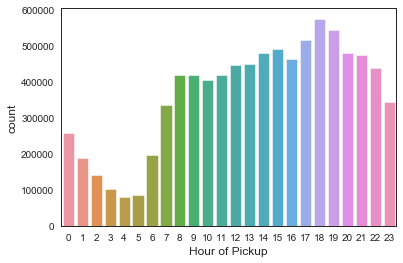

In [65]:
sns.countplot(x=df['pickup_hour']).set_xlabel('Hour of Pickup');

In [66]:
df['day']=df['pickup_time'].apply(lambda x: x.day)


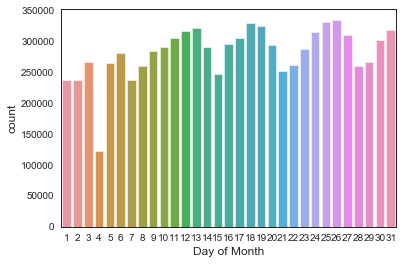

In [67]:
sns.countplot(x=df['day']).set_xlabel('Day of Month');

Clearly something was happening on January 4th, there's almost half as many rides as the second least busy day of the month! Let's explore this further!

In [68]:
df['avg_vel']=df['trip_distance']/df['duration']

In [69]:
df[['trip_distance','extra','hr_window','duration','avg_vel']].groupby('hr_window').mean()

trip_distance     extra  \
hr_window                                                                     
(2017-12-31 23:15:21.603000064, 2018-01-01 00:5...       2.754618  0.493651   
(2018-01-01 00:59:59.995967744, 2018-01-01 01:5...       2.957461  0.494438   
(2018-01-01 01:59:59.991935488, 2018-01-01 02:5...       3.083759  0.492977   
(2018-01-01 02:59:59.987903232, 2018-01-01 03:5...       3.167346  0.491285   
(2018-01-01 03:59:59.983870976, 2018-01-01 04:5...       3.562889  0.486649   
(2018-01-01 04:59:59.979838720, 2018-01-01 05:5...       4.422192  0.451422   
(2018-01-01 05:59:59.975806464, 2018-01-01 06:5...       4.946810  0.007191   
(2018-01-01 06:59:59.971774208, 2018-01-01 07:5...       4.566316  0.000292   
(2018-01-01 07:59:59.967741952, 2018-01-01 08:5...       4.420154  0.000000   
(2018-01-01 08:59:59.963709696, 2018-01-01 09:5...       3.874996  0.000000   
(2018-01-01 09:59:59.959677440, 2018-01-01 10:5...       3.614806  0.000072   
(2018-01-01 10:59:59.955645184, 2018-01-01 11:5...       3.227687  0.000060   
(2018-01-01 11:59:59.951612928, 2018-01-01 12:5...       3.158533  0.000533   
(2018-01-01 12:59:59.947580672, 2018-01-01 13:5...       3.175061  0.000252   
(2018-01-01 13:59:59.943548416, 2018-01-01 14:5...       3.420972  0.000669   
(2018-01-01 14:59:59.939516160, 2018-01-01 15:5...       3.279772  0.002655   
(2018-01-01 15:59:59.935483904, 2018-01-01 16:5...       3.244578  0.036580   
(2018-01-01 16:59:59.931451648, 2018-01-01 17:5...       3.386564  0.039928   
(2018-01-01 17:59:59.927419392, 2018-01-01 18:5...       3.075475  0.041930   
(2018-01-01 18:59:59.923387136, 2018-01-01 19:5...       3.171244  0.060063   
(2018-01-01 19:59:59.919354880, 2018-01-01 20:5...       3.274137  0.473803   
(2018-01-01 20:59:59.915322624, 2018-01-01 21:5...       3.651322  0.474463   
(2018-01-01 21:59:59.911290368, 2018-01-01 22:5...       4.141322  0.468271   
(2018-01-01 22:59:59.907258112, 2018-01-01 23:5...       4.558642  0.464557   
(2018-01-01 23:59:59.903225856, 2018-01-02 00:5...       4.626049  0.471879   
(2018-01-02 00:59:59.899193600, 2018-01-02 01:5...       4.238184  0.467807   
(2018-01-02 01:59:59.895161344, 2018-01-02 02:5...       4.558581  0.467220   
(2018-01-02 02:59:59.891129088, 2018-01-02 03:5...       4.679913  0.464597   
(2018-01-02 03:59:59.887096832, 2018-01-02 04:5...       5.756928  0.436985   
(2018-01-02 04:59:59.883064576, 2018-01-02 05:5...       4.530419  0.399930   
...                                                           ...       ...   
(2018-01-30 17:59:57.120967680, 2018-01-30 18:5...       2.213896  1.029603   
(2018-01-30 18:59:57.116935424, 2018-01-30 19:5...       2.463260  1.008525   
(2018-01-30 19:59:57.112903168, 2018-01-30 20:5...       2.697465  0.499720   
(2018-01-30 20:59:57.108870912, 2018-01-30 21:5...       2.948699  0.491673   
(2018-01-30 21:59:57.104838656, 2018-01-30 22:5...       3.138175  0.489285   
(2018-01-30 22:59:57.100806400, 2018-01-30 23:5...       3.251009  0.491006   
(2018-01-30 23:59:57.096774144, 2018-01-31 00:5...       3.282100  0.488273   
(2018-01-31 00:59:57.092741888, 2018-01-31 01:5...       3.174927  0.489805   
(2018-01-31 01:59:57.088709632, 2018-01-31 02:5...       2.988227  0.490736   
(2018-01-31 02:59:57.084677376, 2018-01-31 03:5...       3.523502  0.487170   
(2018-01-31 03:59:57.080645120, 2018-01-31 04:5...       4.362130  0.477064   
(2018-01-31 04:59:57.076612864, 2018-01-31 05:5...       3.990501  0.418716   
(2018-01-31 05:59:57.072580608, 2018-01-31 06:5...       2.699359  0.005292   
(2018-01-31 06:59:57.068548352, 2018-01-31 07:5...       2.365242  0.000643   
(2018-01-31 07:59:57.064516096, 2018-01-31 08:5...       2.140703  0.000583   
(2018-01-31 08:59:57.060483840, 2018-01-31 09:5...       2.236957  0.001534   
(2018-01-31 09:59:57.056451584, 2018-01-31 10:5...       2.354158  0.001644   
(2018-01-31 10:59:57.052419328, 2018-01-31 11:5...       2.258182  0.001500   
(2018-01-31 11:59:57.04

Looks like we have some ride durations of 0, so let's remove those.

In [70]:
df=df[df['duration']!=0] # get rid of ride durations of 0

In [71]:
df[['trip_distance','extra','hr_window','duration','avg_vel']].corr()

trip_distance     extra  duration   avg_vel
trip_distance       1.000000  0.004968  0.008374  0.997492
extra               0.004968  1.000000  0.015157 -0.000127
duration            0.008374  0.015157  1.000000 -0.000274
avg_vel             0.997492 -0.000127 -0.000274  1.000000

Note here that average velocity is almost perfectly correlated with distance, which makes sense considering longer trips use highways and roads with higher speed limits. Elsewhere there is almost no correlation.

In [72]:
df[['trip_distance','extra','hr_window','duration','avg_vel']].groupby('hr_window').mean().idxmin() 

trip_distance    (2018-01-04 08:59:59.673387008, 2018-01-04 09:...
extra            (2018-01-17 09:59:58.411290368, 2018-01-17 10:...
duration         (2018-01-05 04:59:59.592741888, 2018-01-05 05:...
avg_vel          (2018-01-04 09:59:59.669354752, 2018-01-04 10:...
dtype: object

In [73]:
df[['trip_distance','extra','hr_window','duration','avg_vel']].groupby('hr_window').mean().idxmax()

trip_distance    (2018-01-30 10:59:57.149193472, 2018-01-30 11:...
extra            (2018-01-02 15:59:59.838709760, 2018-01-02 16:...
duration         (2018-01-05 03:59:59.596774144, 2018-01-05 04:...
avg_vel          (2018-01-30 10:59:57.149193472, 2018-01-30 11:...
dtype: object

In [74]:
df[(df['pickup_time']>'2018-01-04 00:00:00') & (df['pickup_time']<'2018-01-05 00:00:00')]['hr_window'].value_counts()

(2018-01-04 07:59:59.677419264, 2018-01-04 08:59:59.673387008]    7565
(2018-01-04 06:59:59.681451520, 2018-01-04 07:59:59.677419264]    6966
(2018-01-04 17:59:59.637096704, 2018-01-04 18:59:59.633064448]    6945
(2018-01-04 08:59:59.673387008, 2018-01-04 09:59:59.669354752]    6708
(2018-01-04 18:59:59.633064448, 2018-01-04 19:59:59.629032192]    6706
(2018-01-04 20:59:59.624999936, 2018-01-04 21:59:59.620967680]    6519
(2018-01-04 19:59:59.629032192, 2018-01-04 20:59:59.624999936]    6308
(2018-01-04 21:59:59.620967680, 2018-01-04 22:59:59.616935424]    6020
(2018-01-04 09:59:59.669354752, 2018-01-04 10:59:59.665322496]    5846
(2018-01-04 16:59:59.641128960, 2018-01-04 17:59:59.637096704]    5772
(2018-01-04 10:59:59.665322496, 2018-01-04 11:59:59.661290240]    5569
(2018-01-03 23:59:59.709677312, 2018-01-04 00:59:59.705645056]    5351
(2018-01-04 12:59:59.657257984, 2018-01-04 13:59:59.653225728]    5331
(2018-01-04 13:59:59.653225728, 2018-01-04 14:59:59.649193472]    5272
(2018-

Here we can see the rides throughout the 4th of January, and we can ignore the rest of those time periods. It's a strange distribution, especially if we compare it to the heatmap of ride frequencies from earlier in this notebook. January 4th was a Thursday, yet we are seeing significantly less rides than we would expect.

Something was definitely happening in on January 4-5. We see that average velocity was a minimum for the entire month from 10-11 AM on the fourth, and trip distance was a minimum from 9-10 AM that same morning. Then on the fifth, we see maximum duration of rides from 4-5 AM, but then minimum duration from 5-6 AM that same morning. With all this considered, my best guess for the time period with inclement weather would be January 4th from 9-10 AM that morning. I think that would explain the lack of rides throughout the day. As for the morning of the fifth, it's probable that snowplows cleared the roads and few people needed rides that morning due to a storm the previous day, so there was sudden, dramatic decrease in ride durations.

#### Best guess: January 4th, 9-10 AM